## Task 1

### Binary numbers

In this exercise, the inputs are positive integers so we define an assertions 
function which verifies that.

In [1]:
def assertions(num:int) -> None:
    '''
    Input: num 
    This function asserts whether the input num is a positive integer
    '''
    assert isinstance(num,int), "Input to binary_digit_sum should be int"
    assert num > 0, "Input integer should be positive"

The first function returns the sum of digits of a number when it is written in binary. We run this function for num=12.

In [2]:
def binary_digit_sum(num: int) -> int:
    ''' 
    Input: num 
    Output: sum of digits of num in binary. 
    Example: num = 12 (base 10) = 1100 (base 2) => output 1+1+0+0 = 2
    '''
    assertions(num)
    res = 0
    while num:  num, res = num//2, res + num%2
    return res

In [3]:
num = 12
print("The binary digit sum of {} is {}.".format(num,binary_digit_sum(num)))

The binary digit sum of 12 is 2.


We now write the binary representation of a number (given in base 10) as a list.

In [4]:
def binary_array(num: int) -> list[str]:
    '''
    Input: num 
    Output: list of digits of num in binary.
    Example: num = 12 (base 10) = 1100 (base 2) => output ['1', '1', '0', '0']
    '''
    assertions(num)
    return list(bin(num)[2:])

In [5]:
print("The binary array representation of {} is {}.".format(num,binary_array(num)))

The binary array representation of 12 is ['1', '1', '0', '0'].


### Groups of people

We now write a function that computes the number of ways we can split a group of people in two.

In [6]:
from math import comb
def num_comb_group_in_half(k: int) -> int:
    '''
    There are 2k people in a group, k>0. 
    Output: Number of ways of spliting the group to two equally sized groups of k people.
    '''
    assertions(k)
    # There are n choose m ways to split a group of n people into groups of m and n-m. 
    # Hence our answer is 2k choose k.
    return comb(2*k,k)

In [7]:
k = 2
print("There are {} ways of splitting a group of {} people in groups of {}.".format(
    num_comb_group_in_half(k), 2* k, k
))

There are 6 ways of splitting a group of 4 people in groups of 2.


Finally we write a function that returns the possible combinations of half-groups that can be formed from the original group.

In [8]:
from itertools import combinations
from typing import Set
def pairs_group_in_half(k: int) -> list[list[Set[int]]]:
    '''
    There are 2k people in a group, k>0. 
    Output: List of all possible pairs 
    Example: for k=1=> 2 people the list of possible pairs is 
    [ [ {0}, {1}], [{1} , {0}] ]
    '''
    assertions(k)
    assert k <= 10, "Splitting a group of more than 20 people results in more than 7*10^5 pairs! Decrease k."
    group = set(range(2*k))
    return [[ set(c) , group - set(c) ] for c in  combinations(range(2*k),k)]

In [9]:
print("Those pairs are {}".format(pairs_group_in_half(k)))

Those pairs are [[{0, 1}, {2, 3}], [{0, 2}, {1, 3}], [{0, 3}, {1, 2}], [{1, 2}, {0, 3}], [{1, 3}, {0, 2}], [{2, 3}, {0, 1}]]


# Stable Matching Problem

Consider two groups of people of equal size $n$; the proposers and the acceptors (men and women in Stable Marriage Problem).
Two preference tables are given; one from the proposers, one from the acceptors. 
Each preference table contains lists of preferences of each member of a group from the other group. 
Consider a simple case where there are two proposers ($A$ and $B$) and two acceptors ($a$ and $b$).
If $A$ prefers $a$ to $b$ and $B$ prefers $b$ to $a$, while $a$ prefers $B$ to $A$ and $b$ prefers $A$ to $B$ 
then the preference tables are <br>
<h6><center>Proposer's Table</center></h6><br>

|  | 1 | 2 |
| --- | --- | --- |
| $A$ |   $a$  |   $b$ |
|$B$  |  $b$   |  $a$ |

<h6><center>Acceptor's Table</center></h6><br>

|  | 1 | 2 |
| --- | --- | --- |
| $a$ |   $B$  |   $A$ |
|$b$  |  $A$   |  $B$ |

The goal is to find a stable matching; a mapping from proposers to acceptors so that there is no acceptor-proposer pair $(X,x)$
such that $X$ prefers $x$ to their matching acceptor <b>and</b> $x$ prefers $X$ to their current proposer. 




In [10]:
import random
from collections.abc import Sequence
from tabulate import tabulate
from typing import Iterable, Dict, List, Sequence, Any, Tuple

## Task 2

There are multiple ways of representing preference tables. A simple approach is to represent them as 
dictionaries whose keys correspond to the people in this group and whose values are preference lists
of people from the other group. For the example above, the proposer and acceptor 
preference tables are represented as
{$A$: [$a$,$b$], $B$: [$b$,$a$]} and 
{$a$: [$B$,$A$], $b$: [$A$,$B$]} respectively.<br>
However, dictionaries are not restrictive enough for our purposes. Further restrictions include,
1. We need to ensure that the values of the dictionary are lists whose values are integer or string (group members),
2. Those preference lists need to have consistent lengths equal to the number of keys (size of acceptors = size of proposers),
3. No duplicate values are allowed in preference lists (duplicate values as keys are not permitted in dictionaries),
4. Preference lists share the same symbols with each other.

To restrict the generality of dictionaries we create a class Table that inherits from dict, but also has a validator method 
which validates the above restrictions and throws errors if they are not satisfied (right_type, consistent_dimension, no_duplicates, same_symbols are class methods that validate 1-4 respectively and return True if they are satisfied and False
otherwise). 

In [11]:
# The type of member's in a group is either an integer or a string.
Sym: Any = int | str 

In [12]:
class Table(dict):
    '''
    This class represents the preference tables that are used in the 
    Stable Matching Problem. 
    '''
    def __init__(self, table: Any):
        super().__init__(table)
        self.validator()
        
    def validator(self) -> None:
        assert self.right_type(), 'Input does not have right type.'
        assert self.consistent_dimension(), 'Input table has a preference list that is not equal to the number of keys.'
        assert self.no_duplicates(), 'Input has duplicate values in a preference list.'
        assert self.same_symbols(), 'Preference lists do not share the same symbols.'
    
    def right_type(self) -> bool:
        '''Assesses whether table is of the right type'''
        return isinstance(self,dict) and  \
                all(isinstance(x, Sequence) for x in self.values()) and \
                all(all(isinstance(y, Sym.__args__) for y in x) for x in self.values())
    
    def consistent_dimension(self) -> bool: 
        '''Assesses whether the table preference lists have consistent dimensions'''
        n: int = len(self)
        return all(len(x) == n for x in self.values())
        
    def no_duplicates(self) -> bool:
        '''Checks whether preference lists contain any duplicates'''
        return all(len(pref_list) == len(set(pref_list))  for pref_list in self.values())
    
    def same_symbols(self) -> bool:
        '''Checks whether preference lists share the same symbols.'''
        prev = None
        for v in self.values():
            if prev is not None and set(v) != prev: return False
            prev = set(v)
        return True

In [13]:
# add 'E': None to the dict to get an error 'Input does not have right type'
# add 'E': ["a"] to the dict to get an error 'Input table has a preference list that is not equal to the number of keys.'
# add a duplicate to any of the lists below to get 'Input has duplicate values in a preference list.'
# change any symbol in any preference list to 'e' to get 'Preference lists do not share the same symbols.'
Table({'A': ['c', 'b', 'd', 'a'], 'B': ['b', 'a', 'c', 'd'], \
        'C': ['b', 'd', 'a', 'c'], 'D': ['c', 'a', 'd', 'b']})

{'A': ['c', 'b', 'd', 'a'],
 'B': ['b', 'a', 'c', 'd'],
 'C': ['b', 'd', 'a', 'c'],
 'D': ['c', 'a', 'd', 'b']}

We can extend this class by adding two more methods. 
As we saw above the table representation does not look appealing. <br>
The tables look better when we use the tabulate library in our __repr__ method. <br>
The other method is get_rank which we will use later in the problem. 
It assigns an attribute self.rank which is a rank table. <br>
Similar to the preference table, the rank table is a dictionary with the same keys and with inverted preference lists <br>
e.g. preference list ["a","b","c"] becomes a ranking dictionary {"a":1,"b":2,"c":3, None: 4}. <br>
None is a key that corresponds to an imaginary undesirable acceptor or proposer. It always has the highest ranking, because they are the most undesirable. 

In [14]:
class Table(Table):
    def get_rank(self) -> None: 
        '''
        Creates a version of the table where the preference lists (values of the dictionary) are inverted.
        A A preference list ["a","b","c"] becomes a ranking dictionary {"a":1,"b":2,"c":3} 
        so that output[X][y] is the ranking of y according to X.
        Rankings begin from zero.
        '''
        self.rank = {key: {v:i for i,v in enumerate(val)} | {None:len(val)}  for key,val in self.items()}
    def __repr__(self) -> str:
        '''
        Tables are printed using the tabulate library for pretty visualization
        '''
        n: int = len(self)
        matrix: List[List[Sym]] = [[k] + list(v) for k, v in self.items()]
        ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
        headers: List[str] = [""] + [ordinal(i) for i in range(1,n+1)]
        return str(tabulate(matrix,tablefmt="fancy_grid",headers=headers))

In [15]:
# This example is given in Ch1 and Ch2 of 
# Stable Marriage and Its Relation to Other Combinatorial Problems.
p1: Table = Table({'A': ['c', 'b', 'd', 'a'], 'B': ['b', 'a', 'c', 'd'], \
        'C': ['b', 'd', 'a', 'c'], 'D': ['c', 'a', 'd', 'b']})
a1: Table =  Table({'a': ['A', 'B', 'D', 'C'], 'b': ['C', 'A', 'D', 'B'], \
        'c': ['C', 'B', 'D', 'A'], 'd': ['B', 'A', 'C', 'D']})
print("Proposer table")
print(p1)
print("Acceptor Table")
print(a1)

Proposer table
╒════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │
╞════╪═══════╪═══════╪═══════╪═══════╡
│ A  │ c     │ b     │ d     │ a     │
├────┼───────┼───────┼───────┼───────┤
│ B  │ b     │ a     │ c     │ d     │
├────┼───────┼───────┼───────┼───────┤
│ C  │ b     │ d     │ a     │ c     │
├────┼───────┼───────┼───────┼───────┤
│ D  │ c     │ a     │ d     │ b     │
╘════╧═══════╧═══════╧═══════╧═══════╛
Acceptor Table
╒════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │
╞════╪═══════╪═══════╪═══════╪═══════╡
│ a  │ A     │ B     │ D     │ C     │
├────┼───────┼───────┼───────┼───────┤
│ b  │ C     │ A     │ D     │ B     │
├────┼───────┼───────┼───────┼───────┤
│ c  │ C     │ B     │ D     │ A     │
├────┼───────┼───────┼───────┼───────┤
│ d  │ B     │ A     │ C     │ D     │
╘════╧═══════╧═══════╧═══════╧═══════╛


The matching (mapping proposers -> acceptors) will be represented as Dict[Sym,Sym] with proposers and acceptors as keys and values respectively. 

## Task 3

We may also want to randomize preference tables. To do so, we extend the Table class to Random_Table and add a method generate_random_table, which takes two sequences of symbols key_syms and val_syms (if they are not given, it uses range(n) as a default for both of them) and returns a preference table (which is then passed to the superclass Table). <br> 
Note that we do not restrict the key symbols to be distinct from the value symbols (our default wouldn't work). 

In [16]:
class Random_Table(Table): 
    def __init__(self,n: int, **kwargs ) -> None:
        table: Dict[int,Sequence[int]] = self.generate_random_table(n,**kwargs)
        super().__init__(table)

    def generate_random_table(self,n: int,key_syms: Iterable[Sym]|None = None , 
                                          val_syms: Iterable[Sym]|None = None) -> Dict[Sym,Sequence[Sym]]:
        if key_syms is None: key_syms = range(n)
        if val_syms is None: val_syms = range(n)
        return {i:random.sample(val_syms,n) for i in key_syms} 

In [17]:
random.seed(1)
import string 
n = 5
proposer_syms = string.ascii_lowercase[:n]
acceptor_syms = string.ascii_lowercase[:n]
p2: Table = Random_Table(n, key_syms=proposer_syms, val_syms = acceptor_syms)
a2: Table = Random_Table(n, key_syms=acceptor_syms, val_syms = proposer_syms)
print("Proposer table")
print(p2)
print("Acceptor Table")
print(a2)

Proposer table
╒════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │ 5th   │
╞════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ a  │ b     │ a     │ e     │ d     │ c     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ b  │ d     │ e     │ c     │ b     │ a     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ c  │ a     │ d     │ e     │ b     │ c     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ d  │ e     │ a     │ c     │ b     │ d     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ e  │ b     │ a     │ e     │ d     │ c     │
╘════╧═══════╧═══════╧═══════╧═══════╧═══════╛
Acceptor Table
╒════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│    │ 1st   │ 2nd   │ 3rd   │ 4th   │ 5th   │
╞════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ a  │ a     │ e     │ b     │ d     │ c     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ b  │ a     │ b     │ d     │ c     │ e     │
├────┼───────┼───────┼───────┼───────┼───────┤
│ c  │ c     │ b     │ e     │

## Task 4

The Stable_Matching class takes two preference tables and validates that the elements of the preference lists of one table 
have a 1-1 correspondence with the keys of the other table. 

In [18]:
class Stable_Matching:
    ''' 
    This class solves the Stable Matching Problem.
    It takes two preference tables (proposer,acceptor) with preference lists as values. 
    '''
    def __init__(self, proposer: Table, 
                       acceptor: Table) -> None:  
        assert isinstance(proposer,Table), 'Proposer is not a Table'   
        assert isinstance(acceptor,Table), 'Acceptor is not a Table' 
        for t in (proposer,acceptor):   t.get_rank()
        self.proposer: Table = proposer 
        self.acceptor: Table = acceptor
        assert self.validate_tables_share_symbols(), 'Symbol mismatch between proposer and acceptor'

    def validate_tables_share_symbols(self) -> bool:
        '''
        Validates that the tables share the same symbols in that for every
        preference list of a table there is a 1-1 mapping to the keys of the other table
        '''
        vals2_in_keys1: bool  =  all( set(x) == set(self.proposer.keys()) for x in self.acceptor.values() )
        vals1_in_keys2: bool  =  all( set(x) == set(self.acceptor.keys()) for x in self.proposer.values() )
        return vals1_in_keys2 and vals2_in_keys1

## Task 5

Another method in the Stable_Matching class is matching_is_stable which takes a matching (as a Dict[Sym,Sym]) and returns True if the matching is stable and False otherwise. <br>
For every acceptor we loop over the proposers that that acceptor prefers more than the current matching proposer.<br>
If any of those proposers prefers that acceptor to their current matching acceptor, the matching is unstable. <br>
After trying all acceptors and not finding any instability we return True (matching is stable). <br>
Note that we use the ranking table self.proposer.rank to check whether the current matching acceptor of the proposer has a higher ranking than the loop acceptor.

In [19]:
class Stable_Matching(Stable_Matching):
    def matching_is_stable(self, matching: Dict[Sym,Sym]) -> bool:
        '''
        For a given matching (which is a dictionary with key=proposer and value=matched_acceptor)
        the algorithm checks whether the matching is stable returning True if it is.
        '''
        acc: Sym   #Acceptor
        prop: Sym  #Proposer
        props: Iterable[Sym] 
        for acc, props in self.acceptor.items():
            for prop in props:
                if acc == matching[prop]:  break
                curr_acc: Sym = matching[prop]
                if self.proposer.rank[prop][acc] < self.proposer.rank[prop][curr_acc]:   
                    return False
        return True

## Task 6

compute_score returns two scores; one for the proposers, the second for the acceptors. <br>
Score = sum of rankings

In [20]:
class Stable_Matching(Stable_Matching):
    def compute_score(self, matching: Dict[Sym,Sym]) -> Tuple[int,int]:
        '''
        Computes the score for proposers and acceptors which is defined as the sum of all the rankings 
        for proposers and acceptors respectively. The higher the score for a group,
        the less the aggregate satisfaction for that group. A score of zero corresponds to complete 
        satisfaction for that group implying that every member of that group got their first preference.
        The highest score is (n-1)*n which corresponds to every member of that group getting their last preference,
        where n is the number of proposers and acceptors.
        '''
        score_proposer: int = sum(self.proposer.rank[prop][matching[prop]] for prop in self.proposer)
        score_acceptor: int = sum(self.acceptor.rank[matching[prop]][prop] for prop in self.proposer)
        return score_proposer, score_acceptor

## Task 7

Finally, the solve_problem method solves the Stable Matching Problem for the given preference tables and returns a matching.<br>
The algorithm can be found in Chapter 2 page 9 of [Stable Marriage and Its Relation to Other Combinatorial Problems](https://ebookcentral.proquest.com/lib/lancaster/detail.action?docID=4908424). <br>
However, instead of removing elements from the preference lists of proposers, we define prop_individual_score which is 
the preference index of a proposer which is incremented by 1 each time they lose their acceptor (same effect as popping the acceptor).  <br> 
As mentioned in the get_rank method, we define an imaginary undesirable acceptor as None and give it the highest rank for all proposers. 

In [21]:
class Stable_Matching(Stable_Matching):
    def solve_problem(self) -> Dict[Sym,Sym]:
        '''
        The Stable Matching Problem is solved using the algorithm descripted in Chapter 2 page 9
        of 'Stable Marriage and Its Relation to Other Combinatorial Problems'.
        A matching (as a dictionary) is returned.
        '''
        prop_individual_score: Dict[Sym,int] = {prop:0 for prop in self.proposer}
        matching: Dict[Sym,Sym|None] = {prop: None for prop in self.proposer}
        inv_matching: Dict[Sym,Sym|None] = {acc: None for acc in self.acceptor}
        prop: Sym|None
        for prop in self.proposer:
            while prop is not None:
                acc: Sym = self.proposer[prop][prop_individual_score[prop]]
                curr_prop: Sym|None = inv_matching[acc]    
                if self.acceptor.rank[acc][prop] < self.acceptor.rank[acc][curr_prop]:
                    matching[prop] = acc
                    prop, inv_matching[acc] = inv_matching[acc], prop
                if prop is not None: prop_individual_score[prop] += 1
        return matching

In [22]:
for proposer, acceptor in [(p1,a1),(p2,a2)]:
    s: Stable_Matching = Stable_Matching(proposer,acceptor)
    opt_matching: Dict[Sym,Sym] = s.solve_problem()
    print(f"Matching found: {opt_matching}")
    print(f"Matching is stable? {s.matching_is_stable(opt_matching)}")
    print(f"Score for (proposers,acceptors) is {s.compute_score(opt_matching)}")
    print("-"*60)

Matching found: {'A': 'd', 'B': 'a', 'C': 'b', 'D': 'c'}
Matching is stable? True
Score for (proposers,acceptors) is (3, 4)
------------------------------------------------------------
Matching found: {'a': 'b', 'b': 'e', 'c': 'd', 'd': 'c', 'e': 'a'}
Matching is stable? True
Score for (proposers,acceptors) is (5, 8)
------------------------------------------------------------


## Task 8

A performance analysis of Stable_Marriage follows. <br>

In [23]:
import time
import matplotlib.pyplot as plt
from numpy import log, exp

In [24]:
def average_execution_time(fun,M=1000,silent=False):
    '''
    Takes a function fun and prints the average time it takes to run fun.
    The number of simulations is M.
    If silent=True, the average execution time is printed instead of executed.
    '''
    start = time.perf_counter()
    for _ in range(M): fun()
    end = time.perf_counter()   
    aet = (end-start)/M
    if silent:  return aet
    print(f"Average time of execution for {fun.__name__} is {aet} seconds.")

In [25]:
def given_example():
    proposer: Table = Table({'A': ['c', 'b', 'd', 'a'], 'B': ['b', 'a', 'c', 'd'], \
        'C': ['b', 'd', 'a', 'c'], 'D': ['c', 'a', 'd', 'b']})
    acceptor: Table =  Table({'a': ['A', 'B', 'D', 'C'], 'b': ['C', 'A', 'D', 'B'], \
        'c': ['C', 'B', 'D', 'A'], 'd': ['B', 'A', 'C', 'D']})
    s = Stable_Matching(proposer,acceptor)
    s.solve_problem()

For the given example that we have considered before, we find its average execution time.

In [26]:
average_execution_time(given_example)

Average time of execution for given_example is 4.5658699935302137e-05 seconds.


We now consider random preference tables of size $n$. We plot the average execution time as we vary $n$.

In [27]:
def random_example(n):
    Stable_Matching(Random_Table(n),Random_Table(n)).solve_problem()

In [28]:
n_vals = list(range(5,101))
aets = list()

In [29]:
for n in n_vals:
    fun = lambda : random_example(n)
    fun.__name__ = f"random_example_n={n}"
    aets.append(average_execution_time(fun,M=20,silent=True))

The theoretical (worst case scenario) time complexity of Stable Matching is $\mathcal{O} (n^2)$. 
In practice, it is a bit faster than that. <br>
Fitting a linear model $\log T = A + B * \log n$, where $T$ is the execution time, 
we get the estimated time complexity $\mathcal{O} (n^B)$

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit( log(n_vals).reshape((-1, 1)) ,  log(aets) )
print(f"The coefficient of linear regression B={round(model.coef_[0],3)}")

The coefficient of linear regression B=1.688


Note that $B<2$, so the expected time is a bit faster than the worst case scenario (not sure whether that is a statistically significant claim)

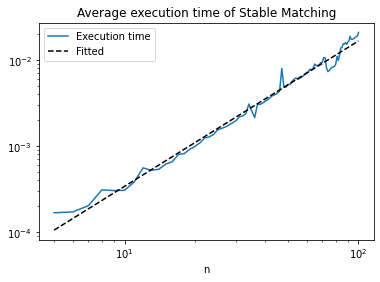

In [31]:
plt.loglog(n_vals,aets)
plt.loglog(n_vals, exp(model.intercept_) * n_vals**model.coef_,\
    color='black', linestyle='dashed')
plt.xlabel(r"n")
plt.title("Average execution time of Stable Matching")
plt.legend(["Execution time","Fitted"])

## Task 9

Finally, we consider the score distributions for proposers and acceptors for different values of $n$.

In [32]:
from numpy import transpose, linspace

In [33]:
def random_score(n):
    '''Returns scores for some random preference tables of size n.'''
    r = Stable_Matching(Random_Table(n), Random_Table(n))
    match = r.solve_problem()
    return r.compute_score(match)

In [34]:
def random_scores(n, M= 1000):
    scores_prop = [None] * M
    scores_acc = [None] * M
    for i in range(M):
        scores_prop[i], scores_acc[i] = random_score(n)
    return scores_prop, scores_acc

In [35]:
def plot_hist(n, **kwargs):
    scores_prop, scores_acc = random_scores(n,**kwargs)
    plt.hist(scores_prop, alpha=0.8)
    plt.hist(scores_acc, alpha=0.8)
    plt.xlabel("Score")
    plt.title(f"Scores for n={n}")
    plt.legend(["Proposer","Acceptor"])

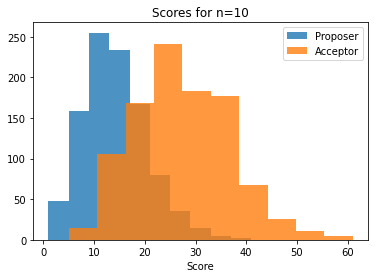

In [36]:
random.seed(1)
plot_hist(10)

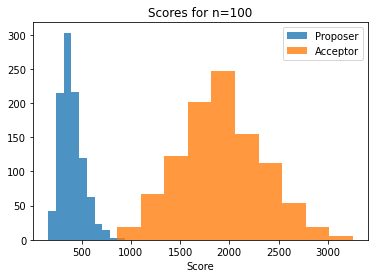

In [37]:
plot_hist(100)

We observe that the acceptor scores are generally higher and the distributions get further and further apart as we increase $n$. <br> 
To verify this claim we vary $n$ up to $1024$.

In [38]:
n_vals =  2**linspace(1,10,10)
scores_prop = [None] * len(n_vals)
scores_acc = [None] * len(n_vals)

In [39]:
### WARNING: This takes a couple of minutes to run
for i, n in enumerate(n_vals):
    scores_prop[i], scores_acc[i] = random_scores(int(n),M=50)

Text(0.5, 1.0, 'Score whisker plots')

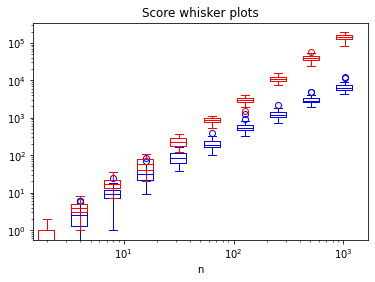

In [40]:
n_vals_str = [str(int(num)) for num in n_vals]
ax = plt.subplot()
for scores,c in  [(scores_prop,"blue"), (scores_acc,"red")]:
    ax.boxplot(transpose(scores), boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                positions = n_vals,
                widths= n_vals/3
                )
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'n')
ax.set_title('Score whisker plots')

As you can see from the whisker plot in loglog axis, there is a linear relationship between $\log S$ and $\log n$, 
where $S$ is the score.
We hence fit a linear model $\log S = A + B * \log n$ for both proposers and acceptors. <br>
Scores are of order $\mathcal{O}(n^{B_P})$ and $\mathcal{O}(n^{B_A})$ for proposers and acceptors respectively, 
where $B_P$ and $B_A$ are the corresponding coefficients from the linear fit.<br>
We expect that $0< B_P < B_A < 2$, since $ 1 \leq S(n) \leq n(n-1) $.

In [41]:
from numpy import mean
for scores, group in  [(scores_prop,"proposer"), (scores_acc,"acceptor")]:
    means = mean(transpose(scores),axis=0)
    model = LinearRegression().fit( log(n_vals).reshape((-1, 1)) ,  log(means) )
    print(f"The coefficient of linear regression for {group} score B={round(model.coef_[0],3)}")

The coefficient of linear regression for proposer score B=1.47
The coefficient of linear regression for acceptor score B=1.913


## Task 10

We now assess whether the code follows the 5 R's as defined by [Benureau and Rougier](https://www.frontiersin.org/articles/10.3389/fninf.2017.00069/full). <br> 
1. <b> Re-runnable</b>; in requirements.txt (using pipreqs) there is a list of all the libraries that have been used in the making of this project. Using pip, the user can install all these packages and their dependencies. whenever a package is imported and used in the code it is clear. However, if Python changes (perhaps Python4) many fundamental functionalities may change which might require many changes in the code.
2. <b> Repeatable</b>; by setting seeds whenever there is randomness, we ensure that the output is always the same (until the seed functions change...). However, we are not saving the outputs of the code to text files, so one has to qualitatively assess whether the outcomes are similar or not.   
3. <b> Reproducible</b>; there are many validation methods for the preference tables which would return errors if they are misspecified. However, the git status is not examined to see whether there is any code impurity and results are not saved. Furthermore, time performance of the algorithm will be different depending on the machine. Finally, in the Table class one can add more keys later on without triggering any validation method. I wasn't sure how to get around that. 
4. <b> Reusable</b>; some documentation is given in this notebook, describing the code and the functions (one can run help(fun) to get the description of that function, class method or class). 
5. <b> Repeatable</b>; test cases have not been considered in this project. Ideally, before even starting the project one must clearly establish all tests to be used in this project, without being able to push code that violates test cases.

Final note; classes Table, Random_Table, Stable_Matching can be found (better written) in stable_matching.py.